# Measuring Opioid Stigma Using the Twitter API and NLP

## Introduction
More than 100 Americans each day die from [opioid overdoses](https://www.cdc.gov/drugoverdose/epidemic/index.html). Expanding access to [medication for addiction treatment (MAT)](http://adai.uw.edu/pubs/infobriefs/MAT.pdf) has the potential to help reverse the epidemic. However, [efforts to expand MAT have been blocked due to a stigmatized view of opioid addiction](https://www.vox.com/science-and-health/2017/7/20/15937896/medication-assisted-treatment-methadone-buprenorphine-naltrexone) as a moral failing rather than a medical condition.

Despite its importance, very little data is available on opioid-related stigma. This is in part because stigma is difficult to measure with traditional tools such as surveys, which may underestimate the pervasiveness of stigma due to [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias).

A potentially valuable source of data to fill this gap is unstructured text data from Twitter, which is [less likely to suffer from social desirability bias](http://journals.sagepub.com/doi/abs/10.1177/0049124115605339) than traditional surveys.

In order to tap into this data source, we can set up a listener that uses Twitter's [Streaming API](https://developer.twitter.com/en/docs/tweets/filter-realtime/overview) to track opioid-related tweets.

## Data Aquisition

### Scraping Twitter

```python
# Import libraries necessary for scraping
import logging
import tweepy
import dataset
from sqlalchemy.exc import ProgrammingError
from requests.packages.urllib3.exceptions import ReadTimeoutError
from textblob import TextBlob
import settings

# Set up logger for debugging
logging.basicConfig(
    filename=f"logs/{__name__}.log",
    level=logging.DEBUG,
    format="%(name)s - %(asctime)s - %(levelname)s - %(message)s",
    filemode='w')
logger = logging.getLogger()
logger.info('Starting log...')

# Define database connection
db = dataset.connect(settings.CONNECTION_STRING)

class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        # Exclude retweets
        if hasattr(status, 'retweeted_status'):
            return

        else:
            # Capture text of tweet
            try:
                text = status.extended_tweet['full_text']
            except AttributeError:
                text = status.text
            # Capture tweet metadata
            tweet_created_utc = status.created_at
            user_followers = status.user.followers_count
            user = status.user.screen_name
            user_location = status.user.location
            tweet_id_str = status.id_str
            user_id_str = status.user.id_str

            # Analyze polarity and subjectivity
            blob = TextBlob(text)
            tweet_polarity = blob.sentiment.polarity
            tweet_subjectivity = blob.sentiment.subjectivity

            # Write tweet and metadata to database
            table = db[settings.TABLE_NAME]
            try:
                table.insert(dict(
                    tweet_id=tweet_id_str,
                    user_id=user_id_str,
                    user=user,
                    user_location=user_location,
                    user_followers=user_followersfollowers,
                    tweet_text=text,
                    tweet_created_utc=tweet_created_utc,
                    tweet_polarity=tweet_polarity,
                    tweet_subjectivity=tweet_subjectivity,
                ))
            except ProgrammingError as err:
                logging.warning(err)

    def on_error(self, status_code):
        if status_code == 420:  # rate limiting
            return False


if __name__ == '__main__':
    # Authenticate using tokens defined in settings.py
    auth = tweepy.OAuthHandler(settings.TWITTER_APP_KEY,
                               settings.TWITTER_APP_SECRET)
    auth.set_access_token(settings.TWITTER_KEY, settings.TWITTER_SECRET)
    api = tweepy.API(auth)

    while True:
        try:
            stream_listener = StreamListener()
            stream = tweepy.Stream(auth=api.auth, listener=stream_listener,
                                   tweet_mode='extended')
            stream.filter(track=settings.TRACK_TERMS, languages=['en'],
                          stall_warnings=True)
        except ReadTimeoutError as err:
            logging.warning(err)
            continue
```

## Data Cleaning

### Load dataset

In [1]:
# Import libraries necessary for data cleaning
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import settings

# Load raw data
DATA_PATH = settings.DATA_PATH # Change for replication
raw_data_file = '{}raw_data.csv'.format(DATA_PATH)
raw_data = pd.read_csv(raw_data_file, parse_dates=['tweet_created_utc'])

# Change maximum display width of columns to see full text of tweets
pd.options.display.max_colwidth = 300

# View first five rows of raw data
rows = raw_data.shape[0]
first_tweet = raw_data['tweet_created_utc'].dt.date.min()
last_tweet = raw_data['tweet_created_utc'].dt.date.max()
print("Raw data contains {:,} tweets scraped between {} and {}.".format(rows, first_tweet, last_tweet))
print("\nFirst five rows of raw data:")
display(raw_data.head())

Raw data contains 713,256 tweets scraped between 2018-03-25 and 2018-09-22.

First five rows of raw data:


,user,user_location,user_followers,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
0,BrookeM_Feldman,"Philadelphia, PA",1803,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",2018-03-25 15:21:00,-0.058333,0.466667
1,NewLeaf_Service,"Trenton, NJ",171,24-hour opioid hotline goes live | WBFO https://t.co/FY00sRgrSZ,2018-03-25 15:21:00,0.136364,0.500000
2,RamonaEid,Denver,4724,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say https://t.co/dkhS5AcqjS",2018-03-25 15:21:00,0.000000,0.000000
3,jimj3125,NaN,35,Trump don't care about anyone or anything except his ego and his money. https://t.co/8o6JvVfWjL,2018-03-25 15:21:00,0.000000,0.000000
4,theGrudgeRetort,United States,2095,Let’s ban theft while we’re at it. https://t.co/hXBENAnKrT,2018-03-25 15:21:00,0.000000,0.000000


### Check missings

In [2]:
# Confirm that only user_location has missing values
for col in list(raw_data):
    if col != 'user_location':
        assert (raw_data[col].isna().sum() == 0)

### Initial text cleaning
To make the tweet text easier to read for coding, this section will:
1. Remove URLs
2. Remove mentions of other Twitter users
3. Remove new line characters
4. Remove extra whitespace
5. Decode HTML

After tweets have been coding, a secondary text cleaning function will be applied to prepare the text for input into natural language processing algorithms.

Hat tips: [Ricky Kim](https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913) and [Dipanjan Sarkar](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html)

In [3]:
def initial_tweet_cleaner(tweet):
    """Remove URLS, mentions, new line characers, whitespace, and HTML"""
    # Remove URLs
    url_pattern = '(http|www\.)[^\s]+'
    # Remove mentions
    mention_pattern = '@[A-Za-z0-9_]+'
    # Remove new line characters
    new_line_pattern = '\\\\n'
    # Combine patterns
    combined_pattern = '|'.join([url_pattern, mention_pattern, new_line_pattern])
    tweet = re.sub(combined_pattern, '', tweet)
    # Remove extra whitespace
    tweet = re.sub(' +', ' ', tweet)
    # Strip HTML
    tweet = BeautifulSoup(tweet, 'html.parser').get_text()
        
    return tweet

In [4]:
# Remove URLs
url_example = raw_data['tweet_text'][14]
print("Tweet containing URL: {}".format(url_example))
url_clean = initial_tweet_cleaner(url_example)
print ("\nTweet cleaned of URL: {}".format(url_clean))

Tweet containing URL: The Big Pharma business plan was to get our people hooked on opioid prescription painkillers. As a reward for this, the CEO of McKesson Pharmaceutical Co. makes $265,000 per day. These Big Pharma execs are the real drug pushers and... https://t.co/a9CI1fJvdS

Tweet cleaned of URL: The Big Pharma business plan was to get our people hooked on opioid prescription painkillers. As a reward for this, the CEO of McKesson Pharmaceutical Co. makes $265,000 per day. These Big Pharma execs are the real drug pushers and... 


In [5]:
# Strip mentions of other Twitter users
mention_example = raw_data['tweet_text'][18]
print("Tweet containing @mention: {}".format(mention_example))
mention_clean = initial_tweet_cleaner(mention_example)
print ("\nTweet cleaned of @mention: {}".format(mention_clean))

Tweet containing @mention: @F00LofPotential I've noticed that states which have legalized marijuana have fewer opiate deaths.

Tweet cleaned of @mention:  I've noticed that states which have legalized marijuana have fewer opiate deaths.


In [6]:
# Remove new line characters
new_line_example = raw_data['tweet_text'][52]
print("Tweet containing URL: {}".format(new_line_example))
new_line_clean = initial_tweet_cleaner(new_line_example)
print ("\nTweet cleaned of URL: {}".format(new_line_clean))

Tweet containing URL: @KrazeeCatLaydee @Wiininiskwe @CandiceMalcolm Meth/Fentanyl drug houses not being ignored. Being replaced by Safe Injection Sites. \nFN individuals way over represented in criminal Justice System but closer to 30% (at least in Youth system).

Tweet cleaned of URL:  Meth/Fentanyl drug houses not being ignored. Being replaced by Safe Injection Sites. FN individuals way over represented in criminal Justice System but closer to 30% (at least in Youth system).


In [7]:
# Decode html
html_example = raw_data['tweet_text'][8]
print("Tweet containing HTML: {}".format(html_example))
html_clean = initial_tweet_cleaner(html_example)
print ("\nTweet cleaned of HTML: {}".format(html_clean))

Tweet containing HTML: Methadone &amp; Suboxone Clinic - Indianapolis, Indiana https://t.co/p5FdAFKFuH

Tweet cleaned of HTML: Methadone & Suboxone Clinic - Indianapolis, Indiana 


In [8]:
stripped_tweets = raw_data.copy()
stripped_tweets['tweet_text'] = stripped_tweets['tweet_text'].map(initial_tweet_cleaner)
stripped_tweets.head()

,user,user_location,user_followers,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
0,BrookeM_Feldman,"Philadelphia, PA",1803,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",2018-03-25 15:21:00,-0.058333,0.466667
1,NewLeaf_Service,"Trenton, NJ",171,24-hour opioid hotline goes live | WBFO,2018-03-25 15:21:00,0.136364,0.500000
2,RamonaEid,Denver,4724,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say",2018-03-25 15:21:00,0.000000,0.000000
3,jimj3125,NaN,35,Trump don't care about anyone or anything except his ego and his money.,2018-03-25 15:21:00,0.000000,0.000000
4,theGrudgeRetort,United States,2095,Let’s ban theft while we’re at it.,2018-03-25 15:21:00,0.000000,0.000000


### Drop quote tweets without keywords

On Twitter, it is possible to quote another user's tweet and add a new Tweet message. Some quote tweets were only captured by the stream listener because the _quoted tweet_ included an opioid-related keyword.  Since the stream listener only captured the URL of the quoted tweet but not its text, the `tweet_text` field for these quote tweets does not contain any opioid-related keywords.

For example, here is how the tweet in row 17 of our data originally appeared on Twitter:
![](../figures/quote_example.png)

But `stripped_tweets['tweet_text'][17]` only contains `'ThankYou!❤️ '`

Since this will not help with our analysis, we will drop these tweets.

In [9]:
# Count tweets that do not contain opioid keywords
# Note: Some tweets were included only because they quoted tweets that contained keywords
track_terms = '|'.join(settings.TRACK_TERMS)
contain_keywords = stripped_tweets['tweet_text'].str.contains(track_terms)
missing_keywords = np.size(contain_keywords) - np.count_nonzero(contain_keywords)

# Drop tweets that do not contain opioid keywords
print("Dropping {:,} tweets missing opioid keywords.".format(missing_keywords))
opioid_tweets = stripped_tweets[contain_keywords].copy()
print("\nData now contains {:,} tweets with opioid keywords".format(opioid_tweets.shape[0]))
opioid_tweets.head()

Dropping 324,776 tweets missing opioid keywords.

Data now contains 388,480 tweets with opioid keywords


,user,user_location,user_followers,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
0,BrookeM_Feldman,"Philadelphia, PA",1803,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",2018-03-25 15:21:00,-0.058333,0.466667
1,NewLeaf_Service,"Trenton, NJ",171,24-hour opioid hotline goes live | WBFO,2018-03-25 15:21:00,0.136364,0.500000
2,RamonaEid,Denver,4724,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say",2018-03-25 15:21:00,0.000000,0.000000
5,ON_YourFeet,"Red Hill, SC",718,"3 Toms River residents allegedly possessed $6,700 in heroin",2018-03-25 15:21:00,-0.100000,0.100000
9,DrKhouryCDC,"Atlanta, GA",9557,Read a CDC paper that used genomics to help map an HIV outbreak associated with opioid use.,2018-03-25 15:21:00,0.000000,0.000000


### Tag users with duplicate tweets and keep first
Automated Twitter accounts, also known as 'bots', are more likely to tweet the same exact same text multiple times than accounts where human users send each message. This section tags accounts that have duplicate tweets and keeps only the first of each duplicate tweet _by user_.

Duplicate tweets _across users_ will be kept for two reasons:
1. The exact same tweet text can be sent by multiple users who share a news story via a share button built in to a website or mobile app without changing the default text.
2. If the same news story with a stigmatizing headline is shared via tweet by multiple users, we would want to count each tweet in our analysis.

In [10]:
# Count duplicates in terms of tweet text
duplicates = opioid_tweets.loc[
    opioid_tweets.duplicated(subset=['user','tweet_text'], keep='first')]

# Identify users with duplicate tweets
users_with_duplicates = set(duplicates['user'])
opioid_tweets['user_bot'] = opioid_tweets['user'].isin(users_with_duplicates)
print("{:,} users tagged as potential bots due to duplicate tweets.".format(len(users_with_duplicates)))

# Move 'user_bot' next to 'user_followers'
cols = opioid_tweets.columns.tolist()
cols = cols[0:3] + cols[-1:] + cols[3:-1]
opioid_tweets = opioid_tweets[cols]

# Drop duplicate tweets within user
print("\nDropping {:,} tweets shared multiple times by the same user.".format(duplicates.shape[0]))
opioid_tweets_unique = opioid_tweets.drop_duplicates(subset=['user','tweet_text'], keep='first').copy()
print("\nData now contains {:,} tweets with opioid keywords. "
      "Tweets are now unique within user.".format(opioid_tweets_unique.shape[0]))
opioid_tweets_unique.head()

3,830 users tagged as potential bots due to duplicate tweets.

Dropping 17,596 tweets shared multiple times by the same user.

Data now contains 370,884 tweets with opioid keywords. Tweets are now unique within user.


,user,user_location,user_followers,user_bot,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
0,BrookeM_Feldman,"Philadelphia, PA",1803,False,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",2018-03-25 15:21:00,-0.058333,0.466667
1,NewLeaf_Service,"Trenton, NJ",171,True,24-hour opioid hotline goes live | WBFO,2018-03-25 15:21:00,0.136364,0.500000
2,RamonaEid,Denver,4724,False,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say",2018-03-25 15:21:00,0.000000,0.000000
5,ON_YourFeet,"Red Hill, SC",718,True,"3 Toms River residents allegedly possessed $6,700 in heroin",2018-03-25 15:21:00,-0.100000,0.100000
9,DrKhouryCDC,"Atlanta, GA",9557,False,Read a CDC paper that used genomics to help map an HIV outbreak associated with opioid use.,2018-03-25 15:21:00,0.000000,0.000000


### Restrict to tweets with identifiable U.S. location
Since analysis will focus on geographic variation in stigma, this section will restrict to tweets from users with an identifiable U.S. location. Because `user_location` is user-entered, this requires significant cleaning.

This section removes tweets with no `user_location`, converts all user locations to lowercase, strips non-letter characters except for commas, and then keeps tweets from users with a location that meets at least one of the following criteria:
1. Ends in a U.S. state postal abbreviation
2. Contains a U.S. state name
3. Contains the name of a large U.S. city

In [11]:
# Count tweets with no location
missing_location = opioid_tweets_unique['user_location'].isna().sum()

# Drop tweets missing user location
print("Dropping {:,} tweets missing user location.".format(missing_location))
opioid_tweets_location = opioid_tweets_unique.loc[
    opioid_tweets_unique['user_location'].notna()].copy()
print("\nData now contains {:,} unique tweets "
      "with opioid keywords and user location.".format(opioid_tweets_location.shape[0]))

Dropping 87,352 tweets missing user location.

Data now contains 283,532 unique tweets with opioid keywords and user location.


In [12]:
# Convert user_location to lower case
opioid_tweets_location['user_location'] = opioid_tweets_location['user_location'].str.lower()

# Remove non-letter characters except for commas
pattern = r'[^a-zA-z\s\,]'
opioid_tweets_location['user_location'] = opioid_tweets_location['user_location'].str.replace(pattern, '')

In [13]:
# Create dictionary to identify user_locations with U.S. state names or abbreviations
# Hat tip: https://gist.github.com/rogerallen/1583593

usa_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

usa_state_abbrev_lower = dict((k.lower(), v.lower()) for k,v in usa_state_abbrev.items())

In [14]:
# Load list U.S. cities with population greater than 100,000
# Note 1: Cities that share a name with populous foreign cities (e.g. Birmingham) are excluded
# Note 2: Duplicates (e.g. Kansas City, KS and Kansas City, MO) are removed
# Source: https://simple.wikipedia.org/wiki/List_of_United_States_cities_by_population
usa_cities_file = '{}usa_cities.csv'.format(DATA_PATH)
usa_cities = pd.read_csv(usa_cities_file)

In [15]:
# Filter 1: Ends with state abbreviation
# Create list of state abbreviations and convert to lowercase
state_abbrevs_list = list(usa_state_abbrev_lower.values())

# Create regex that captures separate state abbreviations at the end of strings or followed by ", usa"
state_abbrevs_regex = '\\b' + '(\,\susa)*$|\\b'.join(state_abbrevs_list) + '(\,\susa)*$'

# Apply filter
opioid_tweets_state_abbrevs = opioid_tweets_location.loc[
    opioid_tweets_location['user_location'].str.contains(state_abbrevs_regex)].copy()
print("\n{:,} unique tweets with opioid keywords have a user location "
      "that ends in a U.S. state abbreviation.".format(opioid_tweets_state_abbrevs.shape[0]))
opioid_tweets_state_abbrevs.head()

/Users/mefryar/anaconda3/envs/opioid-research/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.



91,018 unique tweets with opioid keywords have a user location that ends in a U.S. state abbreviation.


,user,user_location,user_followers,user_bot,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
0,BrookeM_Feldman,"philadelphia, pa",1803,False,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",2018-03-25 15:21:00,-0.058333,0.466667
1,NewLeaf_Service,"trenton, nj",171,True,24-hour opioid hotline goes live | WBFO,2018-03-25 15:21:00,0.136364,0.500000
5,ON_YourFeet,"red hill, sc",718,True,"3 Toms River residents allegedly possessed $6,700 in heroin",2018-03-25 15:21:00,-0.100000,0.100000
9,DrKhouryCDC,"atlanta, ga",9557,False,Read a CDC paper that used genomics to help map an HIV outbreak associated with opioid use.,2018-03-25 15:21:00,0.000000,0.000000
11,deepcow,"tampa, fl",10835,False,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say.",2018-03-25 15:22:00,0.000000,0.000000


In [16]:
# Filter 2: Contain state name
# Create list of state names and convert to lowercase
states_list = list(usa_state_abbrev_lower.keys())

# Convert list to regex that ensures that matches are not part of longer strings
states_regex = '\\b' + '\\b|\\b'.join(states_list) + '\\b'

# Only search tweets not captured by filter 1
no_abbrev = opioid_tweets_location.loc[
    opioid_tweets_location['user_location'].str.contains(state_abbrevs_regex)==False].copy()

# Apply filter
opioid_tweets_states = no_abbrev.loc[
    no_abbrev['user_location'].str.contains(states_regex)].copy()
print("\n{:,} addtional unique tweets with opioid keywords have a user location "
      "that contains a U.S. state.".format(opioid_tweets_states.shape[0]))
opioid_tweets_states.head()

/Users/mefryar/anaconda3/envs/opioid-research/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.



47,493 addtional unique tweets with opioid keywords have a user location that contains a U.S. state.


,user,user_location,user_followers,user_bot,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
18,kimlockhartga,"georgia, usa",12750,False,I've noticed that states which have legalized marijuana have fewer opiate deaths.,2018-03-25 15:22:00,0.000000,0.000000
20,mach229,"pennsylvania, usa",392,False,"Military was always rich. You're just continuing, not creating funding you hateful moron. Nice try linking drugs with Mexicans but the opioid crisis is homegrown so build a wall around pharmaceutical companies unless, of course, the st",2018-03-25 15:23:00,-0.145000,0.770000
22,BradmFROSTBITE,"ohio born, brooklyn raised",62,False,"So let me get this straight...... gun deaths outnumber opioid overdose deaths but only one is labeled an ""epidemic"" that GOP lawmakers care about. #MarchForOurLives #GunControlNow #DumpTrump",2018-03-25 15:23:00,0.100000,0.700000
41,Nevada,"nevada, usa",4082,False,This is an issue of rural prosperity': Nevada roundtable spotlights opioid epidemic in small communities.,2018-03-25 15:24:00,-0.125000,0.200000
58,rileecoyote,"pennsylvania, usa",15186,False,"This should be headlining the news in light of the opioid crisis that we have been inflicted with. Sadly it won’t be, and the process of straightening this mess out in the quickest manor is continuously slowed down by #sidelined science. #inflictedaddiction",2018-03-25 15:26:00,-0.107639,0.540972


In [17]:
# Filter 3: Contain city name
# Create list of city names and convert to lowercase
usa_cities_list = [city.lower() for city in list(usa_cities['City'])]

# Convert list to regex that ensures that matches are not part of longer strings
usa_cities_regex = '\\b' + '\\b|\\b'.join(usa_cities_list) + '\\b'

# Only search tweets not captured by filters 1 or 2
no_state = no_abbrev.loc[
    no_abbrev['user_location'].str.contains(states_regex)==False].copy()

# Apply filter
opioid_tweets_cities = no_state.loc[
    no_state['user_location'].str.contains(usa_cities_regex)].copy()
print("\n{:,} additional unique tweets with opioid keywords have a user location "
      "that contains a U.S. city.".format(opioid_tweets_cities.shape[0]))
opioid_tweets_cities.head()


10,545 additional unique tweets with opioid keywords have a user location that contains a U.S. city.


,user,user_location,user_followers,user_bot,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
2,RamonaEid,denver,4724,False,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say",2018-03-25 15:21:00,0.00,0.00
136,abc7breaking,el paso,88269,False,"Three Texas residents have been arrested in a Toledo, Ohio, drug operation after they tried to mail a 2.2 pounds of heat-sealed fentanyl that authorities said was enough to kill the population of Toledo ""several times over.""",2018-03-25 15:34:00,0.00,0.25
202,alwilsonlsj,lansing,671,False,Prosecutors are increasingly charging people in connection with opioid overdose deaths. But is the system working? Who killed Jody? It depends who you ask via,2018-03-25 15:41:00,-0.20,0.00
217,jenkers_en,san francisco,1331,False,States: Federal money for opioid crisis a small step forward,2018-03-25 15:42:00,-0.25,0.40
289,ShelBelle4,phoenix,100,False,": We just need to tell them not to do drugs. : Eat the ice cream, not the fentanyl. This is a stellar approach to ending the opioid epidemic. Truly, groundbreaking.",2018-03-25 15:49:00,0.25,0.25


### Extract state

In [18]:
# Remove ', usa' ending so that last two characters are state abbreviation
opioid_tweets_state_abbrevs['user_location'] = opioid_tweets_state_abbrevs['user_location'].str.replace(', usa', '')

# Create columns for 'user_state' set equal to last two characters from user_location
opioid_tweets_state_abbrevs['user_state'] = opioid_tweets_state_abbrevs['user_location'].astype(str).str[-2:]

# Check
opioid_tweets_state_abbrevs[['user_location', 'user_state']].head(n=6)

,user_location,user_state
0,"philadelphia, pa",pa
1,"trenton, nj",nj
5,"red hill, sc",sc
9,"atlanta, ga",ga
11,"tampa, fl",fl
14,"tampa, fl",fl


In [19]:
# Create regex expression that contains each state name as match group
states_regex_match_groups = '\\b(' + ')\\b|\\b('.join(states_list) + ')\\b'

# Extract state names into new data frame with one column for each state
# Each row will have missing values for all columns except one
extracted_states = opioid_tweets_states['user_location'].str.extract(r'{}'.format(states_regex_match_groups))

# Replace missing values with empty strings
extracted_states.fillna('', inplace=True)

# Concatenate to get single column with state
opioid_tweets_states['user_state'] = extracted_states.values.sum(axis=1)

# Remap state names to state abbreviations
opioid_tweets_states['user_state'] = opioid_tweets_states['user_state'].replace(usa_state_abbrev_lower)

# Check
opioid_tweets_states[['user_location', 'user_state']].head()

,user_location,user_state
18,"georgia, usa",ga
20,"pennsylvania, usa",pa
22,"ohio born, brooklyn raised",oh
41,"nevada, usa",nv
58,"pennsylvania, usa",pa


In [20]:
# Create regex expression that contains each city name as match group
usa_cities_regex_match_groups = '\\b(' + ')\\b|\\b('.join(usa_cities_list) + ')\\b'
# Extract city names into new data frame with one column for each city
# Each row will have missing values for all columns except one
extracted_cities = opioid_tweets_cities['user_location'].str.extract(r'{}'.format(usa_cities_regex_match_groups))
# Replace missing values with empty strings
extracted_cities.fillna('', inplace=True)
# Concatenate to get single column with city
opioid_tweets_cities['user_city'] = extracted_cities.values.sum(axis=1)

# Create a dictionary mapping cities to states
usa_cities_states_list = [state.lower() for state in list(usa_cities['State'])]
usa_cities_dict = dict(zip(usa_cities_list, usa_cities_states_list))

# Map cities to state names
opioid_tweets_cities['user_state'] = opioid_tweets_cities['user_city'].replace(usa_cities_dict)

# Remap state names to state abbreviations
opioid_tweets_cities['user_state'] = opioid_tweets_cities['user_state'].replace(usa_state_abbrev_lower)

# Drop user_city in advance of append
opioid_tweets_cities.drop(columns='user_city', inplace=True)

# Check
opioid_tweets_cities[['user_location', 'user_state']].head()

,user_location,user_state
2,denver,co
136,el paso,tx
202,lansing,mi
217,san francisco,ca
289,phoenix,az


### Append

In [21]:
# Append tweets captured by all three filters
opioid_tweets_usa = opioid_tweets_state_abbrevs.append([opioid_tweets_states,
                                                        opioid_tweets_cities],
                                                       ignore_index=True)

# Move 'user_state' next to 'user_location'
cols = opioid_tweets_usa.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
opioid_tweets_usa = opioid_tweets_usa[cols]

print("\nData now contains {:,} unique tweets with opioid keywords "
      "and user location mapped to U.S. state.".format(opioid_tweets_usa.shape[0]))
opioid_tweets_usa.head()


Data now contains 149,056 unique tweets with opioid keywords and user location mapped to U.S. state.


,user,user_location,user_state,user_followers,user_bot,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity
0,BrookeM_Feldman,"philadelphia, pa",pa,1803,False,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",2018-03-25 15:21:00,-0.058333,0.466667
1,NewLeaf_Service,"trenton, nj",nj,171,True,24-hour opioid hotline goes live | WBFO,2018-03-25 15:21:00,0.136364,0.500000
2,ON_YourFeet,"red hill, sc",sc,718,True,"3 Toms River residents allegedly possessed $6,700 in heroin",2018-03-25 15:21:00,-0.100000,0.100000
3,DrKhouryCDC,"atlanta, ga",ga,9557,False,Read a CDC paper that used genomics to help map an HIV outbreak associated with opioid use.,2018-03-25 15:21:00,0.000000,0.000000
4,deepcow,"tampa, fl",fl,10835,False,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say.",2018-03-25 15:22:00,0.000000,0.000000


### Descriptive Statistics

In [22]:
# Calculate character length of each tweet
tweet_lengths = opioid_tweets_usa['tweet_text'].str.len()

tweet_lengths.describe()

count    149056.000000
mean        141.302269
std          71.371704
min           8.000000
25%          79.000000
50%         130.000000
75%         206.000000
max         281.000000
Name: tweet_text, dtype: float64

### View sample of tweets for keyword groups

In [23]:
# Keyword groups
generic_opioid_keywords = 'opiate|opioid|opium|heroin'
rx_keywords = 'codine|hydrocodone|morphine|opana|oxycodone|oxycontin|percocet|vicodin'
synthetic_keywords = 'carfentanil|fentanyl'
treatment_keywords = 'burprenorphine|methadone|naltrexone|suboxone|vivitrol'
harm_reduction_keywords = 'injection site|needle exchange|safe injection|supervised injection'
overdose_keywords = 'overdose|naloxone|narcan'

def keyword_sample(df, keywords, label, size=5):
    """Select sample of tweets containing specified keywords."""
    df_temp = df.loc[df['tweet_text'].str.contains(keywords)]
    print("Sample of tweets referencing {}:".format(label))
    return df_temp[['user','user_location','tweet_text']].sample(n=size, random_state=40422)

display(keyword_sample(opioid_tweets_usa, generic_opioid_keywords, 'generic opioids'))

display(keyword_sample(opioid_tweets_usa, rx_keywords, 'prescription opioids'))

display(keyword_sample(opioid_tweets_usa, 'heroin', 'heroin'))

display(keyword_sample(opioid_tweets_usa, synthetic_keywords, 'synthetic opioids'))

display(keyword_sample(opioid_tweets_usa, treatment_keywords, 'opioid addiction treatments'))

display(keyword_sample(opioid_tweets_usa, harm_reduction_keywords, 'harm reduction approaches'))

display(keyword_sample(opioid_tweets_usa, overdose_keywords, 'overdose and overdose reversal'))

Sample of tweets referencing generic opioids:


,user,user_location,tweet_text
140677,colbywg,phoenix,no you’re crying at npr’s opioid story this morning
40148,ManuelasWeb,"new york, ny","Why is Google CEO cracking down on fake opioid treatment, payday lenders, bail bond providers, and even predatory locksmiths--but letting fake, anti-abortion clinics use Google to lure in vulnerable women and lie to them? #ExposeFakeClinics"
59250,FlawdazFinest86,"where dreams come true, fl",Why go from cocaine to heroin? Addiction is such a sad story.
10579,RhodeIslandDOC,cranston ri,RIDOC in the news:This article in today's issue of the Providence Journal highlights RIDOC's contribution reducing the opioids overdose deaths in Rhode Island....
72239,H4ppyPills,"victorville, ca",I can keaster 1 million dollars worth of heroin... dont ask how


Sample of tweets referencing prescription opioids:


,user,user_location,tweet_text
72863,tnicholsmd,"portland, or","I only use morphine, and if I prescribe narcotics, I only write for a few MSIR. When people ask me why or mention the side effects, I tell them that’s the point - patients shouldn’t be enjoying them, they should o"
79687,kevinjayheldman,"queens, ny","According to the affidavit, police seized 120,000 pills, including hydrocodone, hydromorphone and oxycodone, as well as fentanyl and morphine. They also recovered stolen guns, electronics, power tools, clothing, car parts and copper pipes."
109384,Brookslei,texas,I take lyrica for nerve pain helps where I could cut back on hydrocodone. What relief😜😉
27470,not_too_shABBY6,"salisbury, md",dude this song on the radio about never being the same after meeting someone is so annoying because she tries to sing “heroin” to sound like “morphine” to make it rhyme and it bothers me so much😂
80006,MaximizeQOL,"bryn mawr, pa","Methadone better for #NAS tx c/w morphine w both statistically & clinically meaningful dec:-length of stay-length of treatmentNot a surprise to many, but research confirmation is important. Long-term studies in progress#SUD #OpioidCrisis"


Sample of tweets referencing heroin:


,user,user_location,tweet_text
80957,DiFantastico,"cleveland, oh",I am trying to get together a chapbook for Atlas Review's open submissions that includes an essay about dating a heroin-addicted Elvis impersonator who's dead now. You know. My usual cheerful stuff.
9438,KatyAndNews,"charleston, wv","Raleigh Co. deputies arrested 3 people after finding 620 grams, value of $62,000, of heroin at a home in McArthur on Sunday. Deputies also found meth, prescription pills, $2,000 in cash. Deputies arrested Carrie Jewel, Javon Lampkin and Brandon Veal. #59News"
20247,thefontsavant,"danvers, ma","My hometown is known for its abundance of Dunkin Donuts locations, Chinese food restaurants, nail salons, and heroin. Is that anti-hipster?"
42013,devilradio,"milwaukee, wi","Fiebrink entered the jail Aug. 24 suffering from heroin and alcohol withdrawal, but never got a medical screening. On the night of August 27th and..."
452,TonyaRoot,"myrtle beach, sc","ICYMI: RT : #Georgetown man pleads guilty to #heroin distribution, habitual traffic offender & sentenced to prison"


Sample of tweets referencing synthetic opioids:


,user,user_location,tweet_text
104963,DebbyHouse5,"kentucky, usa","Yes, at this point, with all the regs for pain patients & with the illicit fentanyl problem not as prominent as it should be, real patients are being treated horribly & their pain"
110933,WDPAnews,"pittsburgh, pennsylvania",Judge sentences Pittsburgh fentanyl dealer Khalifa Cochran to 10 years in federal prison
62502,KyJohnCGay,"flemingsburg, ky","9 new AUSA’s in WV. Much of effort will likely focus on #opioidcrisis, #heroin, #fentanyl, & #meth."
4615,SafeRxMendocino,"ukiah, ca","What is #fentanyl, the drug that reportedly killed Prince? - Yahoo Lifestyle involved and make a difference in our County with"
98320,reversechapter,florida,"Florida began ""battling"" legal drugs in 2010. It's funny how we apparently still have an ""epidemic"" today. The problem was never caused by ""over prescribing,"" but by the govt's FAILURE to interdict ILLICITLY MANUFACTURED fentanyl analogues. It's easier to attack innocent people."


Sample of tweets referencing opioid addiction treatments:


,user,user_location,tweet_text
70790,NDukich,"elgin, il",I don't follow... What the fuck is this tweet about? Subliminal message or something? I tried to follow it but it made my brain hurt. Is this chick on methadone or something or does she have no life and tagged everyone she could think of?
140071,Gemini_1901,"resevoir hill, baltimore",I live for itRide 4 itCry 4 itGet me highRun ur handsUp my thighI'm gonna cumWith lyricsReal shitLifes knocksHardDrop to kneesAnd call GodLiving in MurderlandGotta b quickOn ur feetSpit DopeNo methadoneHopeLeaningOn barzFake niggasFly cars
140159,katcald,san francisco,"1.Can’t get them 2.Cost prohibitive 3.Bups and methadone are enslaving,have street value,diverted4.Vivitrol needs KOR"
118017,ShatterproofHQ,"new york, usa","After a 23-year battle with opioid addiction, Patience Roberts says suboxone gave her a new, sober life. via"
101730,PharmacyWatson,"louisiana, usa","Buy pills here with a overnight delivery and package will be delivered in discrete,order pain meds or anxiety pills Xanax bars,ritaline ,Vicodin,methadone ,Oxycodone,Oxycontin,valium,Percocet,Roxicodon,Tramadol,txt or whatsapp"


Sample of tweets referencing harm reduction approaches:


,user,user_location,tweet_text
75026,NeedleExchange_,"portland, me","Hamilton County launches state's 1st needle exchange program - | Chattanooga News, Weather & Sports"
146644,GLIDEsf,"san francisco, ca usa","MYTH: Neighborhoods surrounding a safe injection site (SIS) will have more drug use & crime.FACT: SIS reduce public drug use & discarded syringes in areas surrounding SISs & increase public safety.Join us to tour a realistic model of an SIS, 8/28 – 31."
127783,maiasz,new york,"same argument was used against needle exchange: just a bandaid, we need treatment, so let's not save lives while we're trying to get that..."
80597,NeedleExchange_,"portland, me",County to offer needle exchange | Local news |
95213,52Degrees,"california, usa",Heroin injection site?


Sample of tweets referencing overdose and overdose reversal:


,user,user_location,tweet_text
38313,AceDawg11_,"greater soufeast, dc",Cause you not suppose to eat one Tylenol..you can only overdose on things that aren’t good for you
7658,OfficialHemp,"denver, co","Opioid overdose has risen dramatically over the past 15 years and has been implicated in over 500,000 deaths since 2000 -- more than the number of Americans killed in World War II. #OpiodCrisis #OpioidEpidemic #opioid #Medicines"
149044,Editor_JMiller,cleveland,Combatting Texas' durg overdose epidemic [Opinion]
5865,tomdinki,"buffalo, ny",Two Allegany County teenagers have pleaded guilty while a third appears determined to fight the charges in a fatal heroin overdose case:
135009,Lloyd_TV17,"fort worth, texas",He overdose


### Exploratory Visualization - Tweets by keyword group

In [24]:
# Calculate percent of tweets containing specific keywords
# Note: These sum to more than 100% since tweets can contain multiple keywords
total_tweets = opioid_tweets_usa.shape[0]
opioid_pct = opioid_tweets_usa['tweet_text'].str.contains('opioid').sum() / total_tweets * 100
heroin_pct = opioid_tweets_usa['tweet_text'].str.contains('heroin').sum() / total_tweets * 100
overdose_pct = opioid_tweets_usa['tweet_text'].str.contains('overdose').sum() / total_tweets * 100
fentanyl_pct = opioid_tweets_usa['tweet_text'].str.contains('fentanyl').sum() / total_tweets * 100
other_track_terms = [
    'burprenorphine', 'carfentanil', 'codeine', 'injection site',
    'hydrocodone', 'methadone', 'morphine', 'naloxone', 'naltrexone',
    'narcan', 'narcotic', 'needle exchange', 'opana', 'opiate', 'opium',
    'oxycodone', 'oxycontin', 'percocet', 'suboxone', 'safe injection',
    'supervised injection', 'vicodin', 'vivitrol']
other_keywords = '|'.join(other_track_terms)
other_pct = opioid_tweets_usa['tweet_text'].str.contains(other_keywords).sum() / total_tweets * 100

In [25]:
# Plot
import matplotlib.pyplot as plt

categories = [opioid_pct, heroin_pct, overdose_pct, fentanyl_pct, other_pct]
x = np.arange(len(categories))

fig, ax = plt.subplots()
plt.bar(x, categories)
plt.xticks(x, ('Opioid', 'Heroin', 'Overdose', 'Fentanyl', 'Other'))
ax.set_xlabel('Track Terms', fontsize=16)
ax.set_ylabel('Percent of Tweets with Term', fontsize=16)
plt.show()

fig.savefig('../figures/track_terms_breakdown.png', bbox_inches='tight')

<Figure size 640x480 with 1 Axes>

## Create samples for analysis

In [26]:
# Create training sample
analysis_manual_code = opioid_tweets_usa.sample(n=1000, random_state=40422).copy()
analysis_auto_code = opioid_tweets_usa[~opioid_tweets_usa.index.isin(analysis_manual_code.index)].copy()

# Create sub-sample to be coded by second rater for inter-rater reliability
analysis_irr_code = analysis_manual_code.sample(n=100, random_state=40422)

# Export to csv
analysis_manual_code_file = '{}analysis_manual_code.csv'.format(DATA_PATH)
analysis_manual_code.to_csv(analysis_manual_code_file, index_label='id')

analysis_irr_code_file = '{}analysis_irr_code.csv'.format(DATA_PATH)
analysis_irr_code.to_csv(analysis_irr_code_file, index_label='id')

## Manual Coding

Based on a review of the literature about opioid-related stigma, the following instrument was developed to code tweets for language that perpetuates stigmatized views of individuals with substance use disorder and medications for addiction treatment.

**Stigmatized views of individuals with substance use disorder (SUD)**

Does the tweet make reference to any of the following? Check as many as apply.
- Addiction as a choice or result of character flaw (such as immorality, stupidity, weakness)
- Addiction as a sign of poor parenting
- “Clean” to refer to people in recovery
- Individuals with SUD are abusers, addicts, druggies, or junkies (include self-labeling)
- Individuals with SUD are not desirable as neighbors or community members
- Individuals with SUD are not worth saving or deserve to die (e.g. “natural selection”)
- Individuals with SUD are not worth spending money on
- Individuals with SUD are violent/dangerous
- Opioid epidemic is not a problem, is exaggerated, or is something to joke about
- Other: [...]

**Stigmatized view of medications for addiction treatment (MAT)**

Does the tweet make reference to any of the following? Check as many as apply.
- Abstinence as more admirable than maintenance with medication
- Advocating criminal justice approach over public health approach
- “Clean/dirty” to refer to negative/positive toxicology results (exclude references to dirty needles)
- “Detoxification” from medication (buprenorphine/Suboxone or methadone)
- Individuals receiving MAT should not be pregnant or parents
- Injection sites as “drug dens”
- Providers of MAT as drug dealers
- MAT as an addiction or substitution
- MAT as harmful
- Treatment as hopeless
- Other: [...]

This instrument was converted to a Google Form which was filled out separately for each tweet in `analysis_manual_code` and `analysis_irr_code`. The section below creates categorical target features based on these responses and also conducts inter-rater reliability analysis.

In [27]:
# Specify column names of coding form responses
col_names = ['coder', 'id', 'organization', 'stigma_sud_detail', 'stigma_mat_detail', 
             'good_example', 'tough_call', 'errors']

# Initial column is timestamp which is not needed
cols = range(1,9)

# Import coding form responses
coding_form_responses_file = '{}coding_form_responses.csv'.format(DATA_PATH)
coding_form_responses = pd.read_csv(coding_form_responses_file, header=0, names=col_names, usecols=cols)

# Preview
coding_form_responses.head()

,coder,id,organization,stigma_sud_detail,stigma_mat_detail,good_example,tough_call,errors
0,Michael,80121,NaN,NaN,NaN,NaN,NaN,NaN
1,Michael,130551,Organization,NaN,NaN,NaN,NaN,NaN
2,Michael,42311,NaN,NaN,NaN,NaN,NaN,Tweet is unrelated to opioids
3,Michael,75911,Organization,NaN,NaN,NaN,NaN,NaN
4,Michael,138219,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Create categorical target features
coding_form_responses['stigma_sud'] = coding_form_responses['stigma_sud_detail'].notnull()
coding_form_responses['stigma_mat'] = coding_form_responses['stigma_mat_detail'].notnull()
coding_form_responses['stigma_any'] = (coding_form_responses['stigma_sud'] | coding_form_responses['stigma_mat']) 

# Change organization target to boolean
coding_form_responses['organization'] = coding_form_responses['organization'] == 'Organization'

# Check
coding_form_responses.head()

,coder,id,organization,stigma_sud_detail,stigma_mat_detail,good_example,tough_call,errors,stigma_sud,stigma_mat,stigma_any
0,Michael,80121,False,NaN,NaN,NaN,NaN,NaN,False,False,False
1,Michael,130551,True,NaN,NaN,NaN,NaN,NaN,False,False,False
2,Michael,42311,False,NaN,NaN,NaN,NaN,Tweet is unrelated to opioids,False,False,False
3,Michael,75911,True,NaN,NaN,NaN,NaN,NaN,False,False,False
4,Michael,138219,False,NaN,NaN,NaN,NaN,NaN,False,False,False


In [29]:
# Identify tweets coded by both coders
overlap_ids = coding_form_responses.loc[coding_form_responses['coder']=='Kate']['id']
overlap_responses = coding_form_responses.loc[coding_form_responses['id'].isin(overlap_ids)].copy()

# Create separate dataframes for comparison
coder_1_overlap = overlap_responses.loc[overlap_responses['coder']=='Michael'].copy()
coder_2_overlap = overlap_responses.loc[overlap_responses['coder']=='Kate'].copy()

# Sort by id and reset index
coder_1_overlap.sort_values(by=['id'], inplace=True)
coder_1_overlap.reset_index(drop=True, inplace=True)
coder_2_overlap.sort_values(by=['id'], inplace=True)
coder_2_overlap.reset_index(drop=True, inplace=True)

# Check
display(coder_1_overlap.head())
coder_2_overlap.head()

,coder,id,organization,stigma_sud_detail,stigma_mat_detail,good_example,tough_call,errors,stigma_sud,stigma_mat,stigma_any
0,Michael,684,False,NaN,NaN,NaN,NaN,NaN,False,False,False
1,Michael,2677,False,"Individuals with SUD are abusers, addicts, druggies, or junkies (include self-labeling)",NaN,Good example,NaN,NaN,True,False,True
2,Michael,3044,True,NaN,NaN,NaN,NaN,NaN,False,False,False
3,Michael,4550,False,NaN,NaN,NaN,NaN,NaN,False,False,False
4,Michael,5146,False,"Addiction as a choice or result of character flaw (such as immorality, stupidity, weakness)",NaN,NaN,Tough call,NaN,True,False,True


,coder,id,organization,stigma_sud_detail,stigma_mat_detail,good_example,tough_call,errors,stigma_sud,stigma_mat,stigma_any
0,Kate,684,False,NaN,NaN,NaN,NaN,NaN,False,False,False
1,Kate,2677,False,"Individuals with SUD are abusers, addicts, druggies, or junkies (include self-labeling)",NaN,NaN,NaN,NaN,True,False,True
2,Kate,3044,True,NaN,NaN,NaN,NaN,NaN,False,False,False
3,Kate,4550,False,NaN,NaN,NaN,NaN,NaN,False,False,False
4,Kate,5146,False,"Addiction as a choice or result of character flaw (such as immorality, stupidity, weakness)",NaN,NaN,NaN,NaN,True,False,True


In [30]:
# List targets to check inter-rater reliability
target_cols = ['organization', 'stigma_sud', 'stigma_mat', 'stigma_any']

# Calculate agreement between coders
comparison = (coder_1_overlap[target_cols] == coder_2_overlap[target_cols])
comparison['all_targets'] = comparison.all(axis='columns')

# Print inter-rater reliability statistics
irr_cols = target_cols + ['all_targets']
for col in irr_cols:
    agreement = comparison[col].sum()
    print("Coders agreed on {}% of ratings for {}".format(agreement, col))

Coders agreed on 89% of ratings for organization
Coders agreed on 94% of ratings for stigma_sud
Coders agreed on 97% of ratings for stigma_mat
Coders agreed on 94% of ratings for stigma_any
Coders agreed on 84% of ratings for all_targets


### Resolve inter-rater disagreements
In order to reduce the risk of false positives, where coders disagree about whether a tweet contains stigmatizing language, the final training set will code that tweet as not containing stigmatizing language.

In [31]:
# Identify disagreements
disagreements = comparison.all(axis='columns')==False
coder_1_disagreements = coder_1_overlap[disagreements][target_cols].copy()
coder_2_disagreements = coder_2_overlap[disagreements][target_cols].copy()

# If one coder says True and the other says False, code as False
resolution = (coder_1_disagreements & coder_2_disagreements)


### Merge coded targets

In [32]:
# Identify agreements
agreements = coder_1_overlap[~disagreements][target_cols].copy()

# Append
coded_targets = agreements.append(resolution)

# Merge tweet id by index
coded_targets['id'] = coder_1_overlap['id']

# Add responses submitted only by Coder #1
non_overlap_responses = coding_form_responses.loc[~coding_form_responses['id'].isin(overlap_ids)].copy()

# Keep only targets plus id
cols = target_cols + ['id']
non_overlap_targets = non_overlap_responses[cols]

# Append non-overlap targets
coded_targets = coded_targets.append(non_overlap_targets, ignore_index=True)
assert coded_targets.shape[0] == 1000

# Set index to id for merge
coded_targets.set_index('id', inplace=True, verify_integrity=True)

# Merge targets with raw data by id
analysis_training = analysis_manual_code.merge(coded_targets, left_index=True, right_index=True, validate='1:1')

# Check
analysis_training.head()

,user,user_location,user_state,user_followers,user_bot,tweet_text,tweet_created_utc,tweet_polarity,tweet_subjectivity,organization,stigma_sud,stigma_mat,stigma_any
80121,ml_bunker,"chicago, il",il,281,False,"but sex in capitalist society is usually not seen as something to engage with for love of other people but for self-indulgence, its another form of opiate, with people with masturbation addictions",2018-09-04 17:14:00,0.166667,0.408333,False,False,False,False
130551,ABC,new york city worldwide,ny,13852859,False,Multiple inmates and employees at an Ohio state prison received an overdose-reversal drug after being exposed to an unknown substance.,2018-08-29 23:04:00,-0.050000,0.300000,True,False,False,False
42311,kvmc7272,"dallas, tx",tx,1103,False,Pitfalls in that same vein of the attempted suicide conspiracy kidney damage from supposed pill overdose then an extended mental observation afterwards,2018-06-03 16:55:00,-0.050000,0.162500,False,False,False,False
75911,VHAInnovation,"washington, dc",dc,3743,False,In 2016 116 people died every day from an opioid-related drug overdose. Veterans are twice as likely to die. We can change that number by implementing this program. #VHAIETalks #VHAIE,2018-08-30 14:04:00,0.000000,1.000000,True,False,False,False
138219,WOGFilm,ohio,oh,451,False,"Yeah, by someone who was on heroin and speeding. Not sure if I’d fault the victim/scooter here...",2018-09-17 17:52:00,-0.250000,0.888889,False,False,False,False


### Training set descriptive statistics

In [33]:
analysis_training[target_cols].describe()

,organization,stigma_sud,stigma_mat,stigma_any
count,1000,1000,1000,1000
unique,2,2,2,2
top,False,False,False,False
freq,710,934,993,928


## Preparation for analysis

### Prepare text for natural language processing
Hat tips: [Dipanjan Sarkar](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html) and [Matthew Mayo](https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html)

In [34]:
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from contractions import CONTRACTION_MAP

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


def remove_non_ascii_chars(text):
    """Remove non-ASCII characters from list of tokenized words"""
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """Expand contractions in string of text"""
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_special_characters(text, remove_digits=False):
    """Remove all characters except for letters and spaces"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def lemmatize(words):
    """Lemmatize nouns and verbs in list of tokenized words"""    
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='n')
        lemma = lemmatizer.lemmatize(lemma, pos='v')
        lemmas.append(lemma)
    
    joined_lemmas = ' '.join(lemmas)
    return joined_lemmas


def normalize_text(doc):
    """Normalize text document by applying helper functions.""" 
    # Replace hypens and forward slashes with spaces
    doc = re.sub('\-|\/', ' ', doc)
    # Replace non-standard single quote
    doc = doc.replace('’', "'")
    # Remove non-ASCII characters
    doc = remove_non_ascii_chars(doc)
    # Expand contractions    
    doc = expand_contractions(doc)
    # Lowercase the text    
    doc = doc.lower()
    # Remove special characters and digits    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    doc = special_char_pattern.sub(" \\1 ", doc)
    doc = remove_special_characters(doc, remove_digits=True)  
    # Tokenize for stopword removal and lemmatization
    words = doc.split()
    # Remove stopwords
    filtered_words = [word for word in words if word not in stopword_list]
    # Lemmatize text
    normalized_text = lemmatize(filtered_words)
        
    return normalized_text

In [35]:
# Rename tweet_text
analysis_training.rename(index=str, columns={'tweet_text': 'tweet_text_full'}, inplace=True)
analysis_auto_code.rename(index=str, columns={'tweet_text': 'tweet_text_full'}, inplace=True)

# Normalize tweet_text
analysis_training['tweet_text_norm'] = analysis_training['tweet_text_full'].map(normalize_text)
analysis_auto_code['tweet_text_norm'] = analysis_auto_code['tweet_text_full'].map(normalize_text)

# Check
display(analysis_training[['tweet_text_full', 'tweet_text_norm']].head())
analysis_auto_code[['tweet_text_full', 'tweet_text_norm']].head()

,tweet_text_full,tweet_text_norm
80121,"but sex in capitalist society is usually not seen as something to engage with for love of other people but for self-indulgence, its another form of opiate, with people with masturbation addictions",sex capitalist society usually not see something engage love people self indulgence another form opiate people masturbation addiction
130551,Multiple inmates and employees at an Ohio state prison received an overdose-reversal drug after being exposed to an unknown substance.,multiple inmate employee ohio state prison receive overdose reversal drug expose unknown substance
42311,Pitfalls in that same vein of the attempted suicide conspiracy kidney damage from supposed pill overdose then an extended mental observation afterwards,pitfall vein attempt suicide conspiracy kidney damage suppose pill overdose extend mental observation afterwards
75911,In 2016 116 people died every day from an opioid-related drug overdose. Veterans are twice as likely to die. We can change that number by implementing this program. #VHAIETalks #VHAIE,people die every day opioid relate drug overdose veteran twice likely die change number implement program vhaietalks vhaie
138219,"Yeah, by someone who was on heroin and speeding. Not sure if I’d fault the victim/scooter here...",yeah someone heroin speed not sure would fault victim scooter


,tweet_text_full,tweet_text_norm
0,"1)I heard a heartbreaking story from a person using drugs in Kensington on Friday. 20 years ago and long before today's ""opioid epidemic"" hysteria, his mother was abruptly denied prescription opioids she had been taking for a medical condition...",hear heartbreaking story person use drug kensington friday year ago long today opioid epidemic hysteria mother abruptly deny prescription opioids take medical condition
1,24-hour opioid hotline goes live | WBFO,hour opioid hotline go live wbfo
2,"3 Toms River residents allegedly possessed $6,700 in heroin",tom river resident allegedly possess heroin
3,Read a CDC paper that used genomics to help map an HIV outbreak associated with opioid use.,read cdc paper use genomics help map hiv outbreak associate opioid use
4,"$1M in fentanyl seized from Texas trio plotting to mail drugs back from Ohio, authorities say.",fentanyl seize texas trio plot mail drug back ohio authority say


### Shuffle and Split

In [36]:
from sklearn.model_selection import train_test_split

# Stratify since targets are highly unbalanced
X_train_text, X_test_text, Y_train, Y_test = train_test_split(analysis_training['tweet_text_norm'],
                                                              analysis_training['stigma_any'],
                                                              test_size=0.25,
                                                              random_state=40422,
                                                              stratify=analysis_training['stigma_any'])

## Training and Testing Models

### Benchmark: Simple Majority Classifier

In [37]:
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score

majority_prediction = np.zeros(Y_test.shape[0])

accuracy = accuracy_score(Y_test, majority_prediction)
# Note: F1 score will be 0 since there are no predicted positives
# f1_score = fbeta_score(Y_test, majority_prediction, beta=1)
# Note: Area under ROC curve will be 0.5 since the only possible
# thresholds are predict all negative, at which TPR = 0 and FPR = 0,
# and predict all positive at which TPR = 1 and FPR = 1
roc_score = roc_auc_score(Y_test, majority_prediction)

print("Simple Majority Classifier performance: \n"
      "Accuracy: {}\n"
      "F-1 Score: 0.0\n"
      "Area under ROC Curve: {}".format(accuracy, roc_score))

Simple Majority Classifier performance: 
Accuracy: 0.928
F-1 Score: 0.0
Area under ROC Curve: 0.5


### Method 1: TF-IDF + Logistic Regression, SVM, Naive Bayes, Adaboost

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the TfidfVectorizer method
vectorizer = TfidfVectorizer()

# Fit the training data
X_train_transformed = vectorizer.fit_transform(X_train_text)

# Extract features from test data using the same vectorizer
X_test_transformed = vectorizer.transform(X_test_text)

# Get array of feature_names
feature_names = np.asarray(vectorizer.get_feature_names())

In [39]:
# Create training and prediction pipeline
# Hat tip: https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_transformed, Y_train)
    train_time = time() - t0
    print("train time: {:.3f}s".format(train_time))

    t0 = time()
    pred = clf.predict(X_test_transformed)
    test_time = time() - t0
    print("test time: {:.3f}s".format(test_time))

    accuracy = accuracy_score(Y_test, pred)
    f1_score = fbeta_score(Y_test, pred, beta=1)
    roc_auc = roc_auc_score(Y_test, pred)
    
    print("accuracy: {:.3f}\n"
          "f1_score: {:.3f}\n"
          "ROC AUC: {:.3f}".format(accuracy, f1_score, roc_auc))

    if hasattr(clf, 'coef_'):
        print("top 10 keywords:")
        top10 = np.argsort(clf.coef_)[0][-10:]
        print(", ".join(feature_names[top10]))
        print()

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, accuracy, f1_score, roc_auc, train_time, test_time

In [40]:
from time import time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Train and test classifiers
results = []

for name, clf in (
    ("Logistic Regression",
     LogisticRegression(penalty='l1', tol=1e-3, solver='liblinear', random_state=40422)),
    ("Linear Support Vector Machine",
     LinearSVC(penalty='l1', dual=False, tol=1e-3, random_state=40422)),
    ("Naive Bayes",
     MultinomialNB(alpha=.01)),
    ("AdaBoost",
     AdaBoostClassifier(random_state=40422))):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=40422,
          solver='liblinear', tol=0.001, verbose=0, warm_start=False)
train time: 0.008s
test time: 0.000s
accuracy: 0.924
f1_score: 0.240
ROC AUC: 0.575
top 10 keywords:
fighter, file, fill, film, fentanyl, people, heroin, want, shoot, addict


Linear Support Vector Machine
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=40422, tol=0.001,
     verbose=0)
train time: 0.003s
test time: 0.000s
accuracy: 0.924
f1_score: 0.296
ROC AUC: 0.600
top 10 keywords:
ya, 

### Method 2: spaCy + CNN

In [41]:
import spacy
from spacy.util import minibatch, compounding, decaying

def spacy_text_cat(n_iter=20):
    # Create blank Language class
    nlp = spacy.blank('en')  
    print("Created blank English language class model")

    # Add the text classifier to the pipeline
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)

    # Add label to text classifier
    textcat.add_label('stigma_any')
    
    # Prepare data for input spaCy is expecting
    train_texts = tuple(X_train_text)
    test_texts = tuple(X_test_text)
    train_cats = [{'stigma_any': bool(y)} for y in Y_train]
    test_cats = [{'stigma_any': bool(y)} for y in Y_test]
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))
    
    # Train textcat
    nlp.vocab.vectors.name = 'spacy_pretrained_vectors'
    optimizer = nlp.begin_training()
    dropout = decaying(0.25, 0.2, 1e-2)
    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}".format('LOSS', 'A', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # Batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=next(dropout),
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # Evaluate on test data
            scores = evaluate(nlp.tokenizer, textcat, test_texts, test_cats)
        print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}"  # print a simple table
              .format(losses['textcat'], scores['textcat_a'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

    nlp.to_disk('spacy_model/')

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    accuracy  = (tp + tn) / (tp +tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_a': accuracy, 'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

In [42]:
# Train and test CNN model
spacy_text_cat(20)

Created blank English language class model
Training the model...
LOSS 	  A  	  P  	  R  	  F  
14.824	0.928	0.500	0.000	0.000
13.480	0.928	0.500	0.000	0.000
13.441	0.928	0.500	0.000	0.000
13.336	0.928	0.500	0.000	0.000
13.437	0.928	0.500	0.000	0.000
13.497	0.928	0.500	0.000	0.000
13.486	0.928	0.500	0.000	0.000
11.862	0.928	0.500	0.000	0.000
12.055	0.928	0.500	0.000	0.000
11.858	0.928	0.500	0.000	0.000
13.359	0.928	0.500	0.000	0.000
12.974	0.928	0.500	0.000	0.000
12.236	0.928	0.500	0.000	0.000
12.199	0.928	0.500	0.000	0.000
10.793	0.928	0.500	0.000	0.000
8.594	0.924	0.000	0.000	0.000
4.930	0.916	0.200	0.056	0.087
2.907	0.908	0.143	0.056	0.080
2.235	0.904	0.125	0.056	0.077
1.105	0.920	0.333	0.111	0.167


### Refinement

In [43]:
# Import necessary libraries
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score

# Initialize the classifier
clf = MultinomialNB()

# Create the parameters list you wish to tune
parameters = {'alpha': [1, 0.1, 0.01, 0.001]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0)

# Catch F-score is ill-defined warning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
    grid_obj = GridSearchCV(clf, parameters, scorer, cv=5)

    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train_transformed, Y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_
    
    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train_transformed, Y_train)).predict(X_test_transformed)
    best_predictions = best_clf.predict(X_test_transformed)

    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(Y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(Y_test, predictions, beta=1.0)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, best_predictions, beta=1.0)))
    print("Final precision on the testing data: {:.4f}".format(precision_score(Y_test, best_predictions)))
    print("Final recall on the testing data: {:.4f}".format(recall_score(Y_test, best_predictions)))
    print("The optimized model has alpha = {}.".format(best_clf.alpha))
    
print("Top 10 keywords:")
top10 = np.argsort(best_clf.coef_)[0][-10:]
print(", ".join(feature_names[top10]))

Unoptimized model
------
Accuracy score on testing data: 0.9280
F-score on testing data: 0.0000

Optimized Model
------
Final accuracy score on the testing data: 0.9440
Final F-score on the testing data: 0.3636
Final precision on the testing data: 1.0000
Final recall on the testing data: 0.2222
The optimized model has alpha = 0.01.
Top 10 keywords:
like, needle, drug, get, want, shoot, people, not, heroin, addict


## Auto-coding

Given that the Naive Bayes classifier had the highest F1-score, I will use that model to autocode the rest of the tweets.

In [44]:
# Train named model
naive_bayes = MultinomialNB(alpha=.01)
naive_bayes.fit(X_train_transformed, Y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

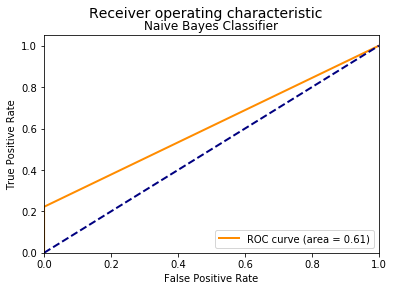

In [45]:
from sklearn.metrics import roc_curve, auc

def plot_roc(test, pred, title):
    """Plot receiver operating characteristic curve"""
    fpr, tpr, __ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.suptitle('Receiver operating characteristic', fontsize=14)
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    return

plot_roc(Y_test, naive_bayes.predict(X_test_transformed), 'Naive Bayes Classifier')

In [46]:
# Extract features from auto_code data using
# the same vectorizer trained earlier
auto_code_text_transformed = vectorizer.transform(analysis_auto_code['tweet_text_norm'])

analysis_auto_code['stigma_any'] = naive_bayes.predict(auto_code_text_transformed)

In [47]:
analysis_auto_code[['user', 'tweet_text_full', 'stigma_any']].loc[
    ~analysis_auto_code['stigma_any']].sample(10, random_state=40422)

,user,tweet_text_full,stigma_any
45351,qballjeff,How about taking care of the children and families that have been separated due to opioid epidemic in Ohio your doing nothing to help them oh that's right your on the stump for 2020 Democratic ticket,False
42396,MarziayW,I wish I had gone one step further then telling thebheroin addict to leave me alone I wish I had said to myself in going to hide from the heroin addicts.,False
134205,DonnaYoungDC,"On #opioidcrisis, says change is coming for monitoring/reporting/communication; going to accelerate communication.This year, #CDC will be correcting contracting issues.#RAForum18 #Overdose #OpioidEpidemic",False
112790,rishi_b_Eshita,He was not prescribed fentanyl. Where did you get this info. Is Paisley Park telling folks this?,False
56261,OpioidHelpNow,Comparison of buprenorphine and methadone in the treatment of opioid dependence | American Journal of Psychiatry,False
114941,yonidanyell,"Becuz, I asked pharmacists how they felt, AND why this INSANE response. They stated becuz the argument is ""oh, opiods lead to worse drugs, like heroin."" WELL, when you deny them legal meds, they RUN to the DRUG lord. Coun",False
143316,quexieqbal7,Obviously she did not know the whole story tapi tetap nak limelight konon heroin Melayu...,False
52667,vicejunky,"literally a drug in mexico or somewhere that helped people kick heroin pretty easily, and they banned it in the US",False
127629,smol_angel,My grandma gave me some cough syrup to take before bed and I didn't realize it had codeine in it so I smoked a bowl first and....guuuuurl,False
95468,NuckChorris16,Whoa there. Take it easy. Be careful. You may be making the painkilling power of the fentanyl less effective too.,False


In [48]:
analysis_auto_code[['user', 'tweet_text_full', 'stigma_any']].loc[
    analysis_auto_code['stigma_any']].sample(10, random_state=40422)

,user,tweet_text_full,stigma_any
123167,AnyssaVela,You can snort heroin,True
59820,charkszn7,Imagine doing heroin in 2018🤣,True
124871,KevinGutzman,"Hmm, what would a suicidal heroin junkie say?",True
42527,Fuctupmind,Could you imagine a California heroin Christmas tree?,True
125490,33DoubleD1,I guess the plastic used in the free heroin syringes gets a mulligan go figure,True
25493,johnathanalxndr,dope like fuckn heroin,True
38598,kcevans56,This is as stupid as giving heroin addicts needles for free in the Streets of San Francisco and LA,True
45837,MKehoe88,"I think you’re a little too stoned there Snoop. Never done heroin in my life, never been a junkie. If you’re gonna come at someone maybe do your research so you dont come off like a clown.",True
6363,B_inShortsville,"But if Homer & Jethro; the landlady’s 1st-call opioid addicts, err... “handymen” don’t work Easter weekend, Zombie Jesus probably doesn’t either.",True
23478,BluSturmer81,I don't need to buy a $9 latte to shoot heroin in your bathroom? SWEET. Thanks #Starbucks,True


## Analysis

### Measure Stigma By State

In [49]:
# Prepare data for append
final_cols = ['user', 'user_location', 'user_state', 'user_bot', 'tweet_text_full', 'stigma_any']
analysis_training_append = analysis_training[final_cols]
analysis_auto_code_append = analysis_auto_code[final_cols]

# Append
analysis_combined = analysis_training_append.append(analysis_auto_code_append)

# Drop tweets from potential bots
analysis_combined = analysis_combined.loc[analysis_combined['user_bot']==False].copy()

In [50]:
stigma_by_state = analysis_combined.groupby('user_state').stigma_any.agg(['count', 'sum'])
stigma_by_state.rename(columns={'count': 'total_tweets', 'sum': 'stigma_tweets'},
                       inplace=True)

stigma_by_state['stigma_tweets_pct'] = (stigma_by_state['stigma_tweets'] /
                                        stigma_by_state['total_tweets']) * 100

stigma_by_state['state'] = stigma_by_state.index.str.upper()
cols = stigma_by_state.columns.tolist()
cols = cols[-1:] + cols[0:-1]
stigma_by_state = stigma_by_state[cols]
stigma_by_state.reset_index(drop=True, inplace=True)

stigma_by_state.head()

,state,total_tweets,stigma_tweets,stigma_tweets_pct
0,AK,292,7.0,2.397260
1,AL,1203,13.0,1.080632
2,AR,693,5.0,0.721501
3,AZ,2528,35.0,1.384494
4,CA,14941,259.0,1.733485


### Load and merge overdose data from CDC

In [51]:
# Import state opioid overdose totals from CDC
# https://wonder.cdc.gov/mcd-icd10.html
cdc_data_file = '{}state_opioid_od_total_2016.txt'.format(DATA_PATH)
cdc_state_data = pd.read_csv(cdc_data_file,
                             sep='\t', usecols=[1,4,6],
                             skipfooter=69, engine='python')

# Clean column headers
cdc_state_data.rename(columns={'State': 'state', 'Population': 'population',
                               'Age Adjusted Rate': 'overdoses_per_100k'},
                       inplace=True)

# Replace state name with abbreviation
cdc_state_data['state'] = cdc_state_data['state'].map(usa_state_abbrev)

# Merge
analysis_by_state = cdc_state_data.merge(stigma_by_state, on=['state'], validate='1:1')

analysis_by_state

,state,population,overdoses_per_100k,total_tweets,stigma_tweets,stigma_tweets_pct
0,AL,4863300,7.0,1203,13.0,1.080632
1,AK,741894,10.8,292,7.0,2.397260
2,AZ,6931071,10.1,2528,35.0,1.384494
3,AR,2988248,4.5,693,5.0,0.721501
4,CA,39250017,4.3,14941,259.0,1.733485
5,CO,5540545,8.5,2556,28.0,1.095462
6,CT,3576452,23.4,1726,21.0,1.216686
7,DE,952065,16.2,389,5.0,1.285347
8,DC,681170,26.7,6459,42.0,0.650255
9,FL,20612439,13.7,7570,96.0,1.268164


In [52]:
# Calculate median number of tweets per state
median_total_tweets = analysis_by_state['total_tweets'].median()

# Calculate median number of stigmatizing tweets per state
median_stigma_tweets = analysis_by_state['stigma_tweets'].median()

print("Median tweets per state: {:,.0f}\n"
      "Meidan stigmatizing tweets per state: {:.0f}".format(median_total_tweets, median_stigma_tweets))

Median tweets per state: 1,612
Meidan stigmatizing tweets per state: 22


### Figure 1: Visualization of Tweets per State with Breakdown by Drug Type

In [53]:
import plotly
import plotly.plotly as py

from settings import PLOTLY_API_KEY

plotly.tools.set_credentials_file(username='mefryar', api_key=PLOTLY_API_KEY)

scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], [0.4, 'rgb(188,189,220)'],
       [0.6, 'rgb(158,154,200)'], [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]
            
data = [dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = analysis_by_state['state'],
            z = analysis_by_state['stigma_tweets_pct'].round(2),
            locationmode = 'USA-states',
            marker = dict(
                line = dict(
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = 'Pct. of Tweets with Stigmatizing Lang.')
            )
        ]

layout = dict(
            title = '<b>Percent of Opioid-Related Tweets with Stigmatizing Language</b><br>' + \
                    '(Hover for Details)',
            geo = dict(
                scope='usa',
                projection=dict(type='albers usa'),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)'
            )
        )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='state-cloropleth-tweets')

/Users/mefryar/anaconda3/envs/opioid-research/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### Figure 2: Relationship between Stigma and Overdose Deaths

In [54]:
# Separate states in top quarter from states in bottom three-quarters
cutoff = analysis_by_state['overdoses_per_100k'].quantile(0.75)

analysis_top_25 = analysis_by_state.loc[analysis_by_state['overdoses_per_100k'] >= cutoff].copy()
analysis_top_25.reset_index(drop=True, inplace=True)

analysis_bottom_75 = analysis_by_state.loc[analysis_by_state['overdoses_per_100k'] < cutoff].copy()
analysis_bottom_75.reset_index(drop=True, inplace=True)

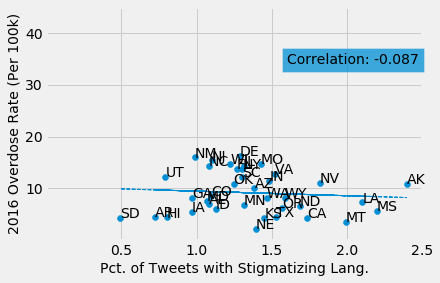

In [55]:
from scipy.stats import pearsonr

# Graph relationship for bottom three-quarters
x = analysis_bottom_75['stigma_tweets_pct']
y = analysis_bottom_75['overdoses_per_100k']

# Set style
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

# Plot points
ax.scatter(x,y)

# Label points
for i, txt in enumerate(analysis_bottom_75['state']):
    ax.annotate(txt, ((x[i]),(y[i])))

# Label axes
ax.set_xlabel('Pct. of Tweets with Stigmatizing Lang.', fontsize=14)
ax.set_ylabel('2016 Overdose Rate (Per 100k)', fontsize=14)

# Set axes limits
ax.set_xlim([0,2.5])
ax.set_ylim([0,45])

# Set axes ticks
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])
plt.yticks([10, 20, 30, 40])

# Calculate and plot correlation
A = np.vstack([x, np.ones(len(x))]).T
m,c = np.linalg.lstsq(A, y, rcond=None)[0]
ax.plot(x, x*m+c, '--', linewidth=1)
ax.text(1.6, 34, 'Correlation: {}'.format(format(pearsonr(x, y)[0], '.3f')),
        bbox={'pad':5, 'alpha':0.75}, fontsize=14)

fig.savefig('../figures/overdoses_vs_stigma_bottom_75.png', bbox_inches='tight')

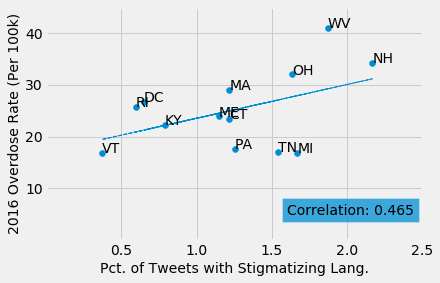

In [56]:
# Graph relationship for bottom three-quarters
x = analysis_top_25['stigma_tweets_pct']
y = analysis_top_25['overdoses_per_100k']

# Set style
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

# Plot points
ax.scatter(x,y)

# Label points
for i, txt in enumerate(analysis_top_25['state']):
    ax.annotate(txt, ((x[i]),(y[i])))

# Label axes
ax.set_xlabel('Pct. of Tweets with Stigmatizing Lang.', fontsize=14)
ax.set_ylabel('2016 Overdose Rate (Per 100k)', fontsize=14)

# Set axes limits
ax.set_xlim([0,2.5])
ax.set_ylim([0,45])

# Set axes ticks
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])
plt.yticks([10, 20, 30, 40])

# Calculate and plot correlation
A = np.vstack([x, np.ones(len(x))]).T
m,c = np.linalg.lstsq(A, y, rcond=None)[0]
ax.plot(x, x*m+c, '--', linewidth=1)
ax.text(1.6, 5, 'Correlation: {}'.format(format(pearsonr(x, y)[0], '.3f')),
        bbox={'pad':5, 'alpha':0.75}, fontsize=14)

fig.savefig('../figures/overdoses_vs_stigma_top_25.png', bbox_inches='tight')

In [57]:
# Robustness check
cutoffs = [0.5, 0.6, 0.7, 0.8]
for cutoff in cutoffs:
    cut = analysis_by_state['overdoses_per_100k'].quantile(cutoff)
    df = analysis_by_state.loc[analysis_by_state['overdoses_per_100k'] >= cut].copy()
    
    x = df['stigma_tweets_pct']
    y = df['overdoses_per_100k']
    print("Cutoff: {}, Correlation: {}".format(cutoff, format(pearsonr(x, y)[0], '.3f')))

Cutoff: 0.5, Correlation: 0.282
Cutoff: 0.6, Correlation: 0.357
Cutoff: 0.7, Correlation: 0.449
Cutoff: 0.8, Correlation: 0.507


In [58]:
# Total overdose deaths in top-quartile
analysis_top_25['actual_deaths'] = (analysis_top_25['overdoses_per_100k'] 
                                    * (analysis_top_25['population'] / 1e5))

analysis_top_25['low_stigma_deaths'] = (analysis_top_25['overdoses_per_100k'].min() 
                                       * (analysis_top_25['population'] / 1e5))

actual_deaths = analysis_top_25['actual_deaths'].sum()
low_stigma_deaths = analysis_top_25['low_stigma_deaths'].sum()
lives_saved = actual_deaths - low_stigma_deaths

print("Lives saved in 2016 among top quartile if overdose rates were reduced"
      " to Vermont levels: {:,.0f}".format(lives_saved))

Lives saved in 2016 among top quartile if overdose rates were reduced to Vermont levels: 4,123
